<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/ChannelFlows/CpMaxCurves/CpMaxCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sympy as sp
import numpy as np
from scipy.optimize import fsolve, fmin, minimize_scalar, curve_fit
import matplotlib.pyplot as mpl

In [2]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py &> /dev/null

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']

# **Warning**

Before running this notebook locus of optimal values of $C_P$ as function of $C_T$ and $\mathrm{Fr}_1$ in the notebook: 

https://github.com/joaochenriques/MCTE_2022/blob/main/ChannelFlows/DiskActuator/SensitivityAnalysis_V02.ipynb

In [3]:
def compute_C_T_and_C_P( Fr4b, Fr1, B ): 

    # These Eqs. are described in the course Lecture Notes

    ζ4 = (1/2.)*Fr1**2 - 1/2.*Fr4b**2 + 1.0
    
    Fr4t = (Fr1 - Fr4b*ζ4 + np.sqrt(B**2*Fr4b**2 - 2*B*Fr1**2 + 2*B*Fr1*Fr4b \
            + B*ζ4**2 - B + Fr1**2 - 2*Fr1*Fr4b*ζ4 + Fr4b**2*ζ4**2))/B

    ζ4b =  (Fr1 - Fr4t*ζ4)/(Fr4b - Fr4t)
    ζ4t = -(Fr1 - Fr4b*ζ4)/(Fr4b - Fr4t)
    
    Fr2t = Fr4t*ζ4t/B

    C_T = (Fr4b**2 - Fr4t**2)/Fr1**2
    C_P = C_T*Fr2t/Fr1

    return C_T, C_P

def find_minus_C_P( Fr4b, Fr1, B ): 
    # function created to discard the C_T when calling "compute_C_T_and_C_P"
    C_T, C_P = compute_C_T_and_C_P( Fr4b, Fr1, B ) 
    return -C_P # Minus C_P to allow minimization

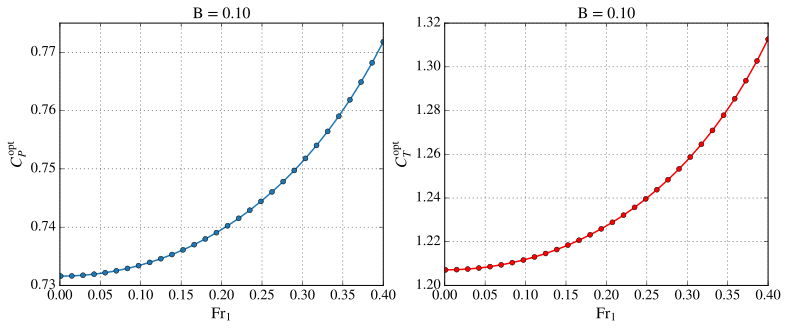

In [11]:
# Blockage factor 
B = 0.1

# define Fr1 interval and number of points
Fr1_min = 1E-3
Fr1_max = 0.4
Fr1_num = 30

Fr1_opt_vec = np.linspace( Fr1_min, Fr1_max, Fr1_num )

C_P_opt_vec = np.zeros( Fr1_num )
C_T_opt_vec = np.zeros( Fr1_num )

for i, Fr1 in enumerate( Fr1_opt_vec ):

  res = minimize_scalar( find_minus_C_P, args=(Fr1, B), bounds=[0,1], method='bounded', 
                         options={ 'xatol': 1e-08, 'maxiter': 500, 'disp': 1 } )
  Fr4b = res.x # optimal value

  C_T, C_P = compute_C_T_and_C_P( Fr4b, Fr1, B )

  C_T_opt_vec[i] = C_T
  C_P_opt_vec[i] = C_P

fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.19 )

ax1.plot( Fr1_opt_vec, C_P_opt_vec, 'o-' )
ax1.set_title( "B = %.2f" % B )
ax1.set_xlabel("$\mathrm{Fr}_1$")
ax1.set_ylabel("$C_P^\mathrm{opt}$")
ax1.grid()


ax2.plot( Fr1_opt_vec, C_T_opt_vec, 'ro-' )
ax2.set_title( "B = %.2f" % B )
ax2.set_xlabel("$\mathrm{Fr}_1$")
ax2.set_ylabel("$C_T^\mathrm{opt}$")
ax2.grid()

mpl.savefig('CP_CT_optimal_B%4.2f.pdf' % B, bbox_inches='tight', pad_inches=0.02);

## **Polynomial fitting**

Fit a polynomial of the type 

$$ a x^6 + b x^4 + c x^2 + d$$

to the optimal $C_T$ and $C_P$. This polynomial has only even monomial to avoid double curvature.


In [5]:
def fitting_func( x, a, b, c, d ):
    x2 = x*x
    return ( ( ( a * x2 + b ) * x2 + c ) * x2 ) + d

C_P_popt, C_P_pcov = curve_fit( fitting_func, Fr1_opt_vec, C_P_opt_vec )
C_T_popt, C_P_pcov = curve_fit( fitting_func, Fr1_opt_vec, C_T_opt_vec )

## **Optimal $C_T$ and $C_P$**

In [6]:
sFr_1, sC_P, sC_T = sp.symbols( "\mathrm{Fr}_1, C_\mathrm{P}, C_\mathrm{T}" )
eqCP = sp.Eq( sC_P, fitting_func( sFr_1, *C_P_popt ) )
sp.expand( eqCP )

Eq(C_\mathrm{P}, 0.950469005167641*\mathrm{Fr}_1**6 + 0.235239872607705*\mathrm{Fr}_1**4 + 0.189205872691749*\mathrm{Fr}_1**2 + 0.731588254027737)

In [7]:
eqCT = sp.Eq( sC_T, fitting_func( sFr_1, *C_T_popt ) )
sp.expand( eqCT )

Eq(C_\mathrm{T}, 3.47964521886281*\mathrm{Fr}_1**6 + 0.595218942569153*\mathrm{Fr}_1**4 + 0.474817875529668*\mathrm{Fr}_1**2 + 1.20709928871966)

## **Plot results of the optimization and interpolation of the maxima**

In [8]:
fit_C_P = fitting_func( Fr1_opt_vec, *C_P_popt )
fit_C_T = fitting_func( Fr1_opt_vec, *C_T_popt )

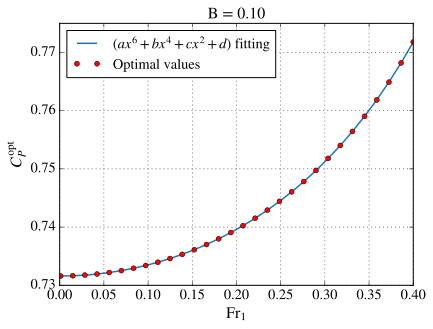

In [9]:
mpl.plot( Fr1_opt_vec, fit_C_P, label="$(ax^6+bx^4+cx^2+d)$ fitting" )
mpl.plot( Fr1_opt_vec, C_P_opt_vec, 'ro', label="Optimal values" )

mpl.title( "B = %.2f" % B )
mpl.xlabel("$\mathrm{Fr}_1$")
mpl.ylabel("$C_P^\mathrm{opt}$")
mpl.legend(loc='upper left')
mpl.grid()

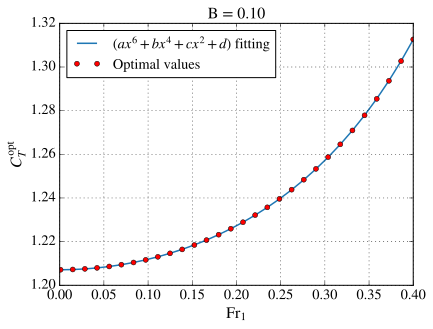

In [10]:
mpl.plot( Fr1_opt_vec, fit_C_T, label="$(ax^6+bx^4+cx^2+d)$ fitting" )
mpl.plot( Fr1_opt_vec, C_T_opt_vec, 'ro', label="Optimal values" )

mpl.title( "B = %.2f" % B )
mpl.xlabel("$\mathrm{Fr}_1$")
mpl.ylabel("$C_T^\mathrm{opt}$")
mpl.legend(loc='upper left')
mpl.grid()